#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

#### This notebook does not include the raw data files. In order to run the notebook, you need to download them from https://fastmri.med.nyu.edu/

In [1]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [2]:
from google.colab import drive

# 挂载 Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# 查看 Google Drive 中的文件
!ls /content/drive/My\ Drive


 AI-Economist			    'MultiModal Learning'       UOM
'Colab Notebooks'		     resources		        未命名绘图.drawio
 file_brain_AXFLAIR_200_6002452.h5   resources2
 GCN+GRU+attention		     train.zip.parter（副本）


In [4]:
file_name = '/content/drive/My Drive/file_brain_AXFLAIR_200_6002452.h5'
hf = h5py.File(file_name)

In [5]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.0004375913018608077, 'norm': 0.08163536547595895, 'patient_id': '2c6c660f8b4000c29e7e1aa875a95512a8afafad14b3cf30fef1c44a34fc963c'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [6]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(16, 20, 640, 320)


In [7]:
slice_kspace = volume_kspace[15] # Choosing the 20-th slice of this volume

Let's see what the absolute value of k-space looks like:

In [8]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

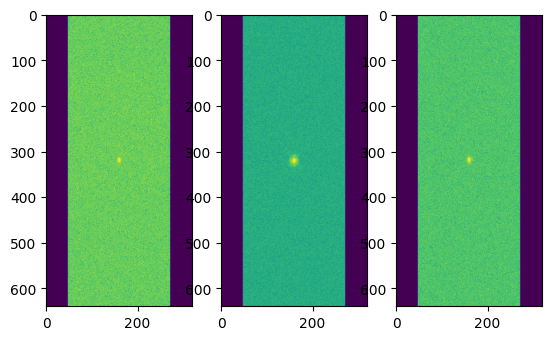

In [9]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [17]:
!pip install fastmri

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 42.3 MB/s eta 0:00:00
  Created wheel for runstats: filename=runstats-2.0.0-py3-none-any.whl size=12358 sha256=39c4407c4710750ebc27df2f8318894d93a07d2c35f2ddbaca80c90c1cb46435
  Stored in directory: /root/.cache/pip/wheels/ab/f0/e7/de0153d4ef82770beff902f778ab825fa24c3534cb63564197
Successfully built runstats


In [18]:
import fastmri
from fastmri.data import transforms as T

In [19]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

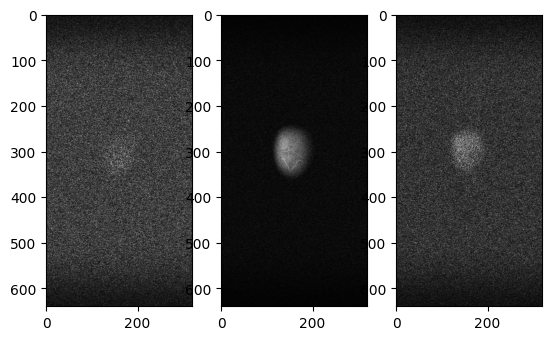

In [20]:
show_coils(slice_image_abs, [0, 5, 10], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [21]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

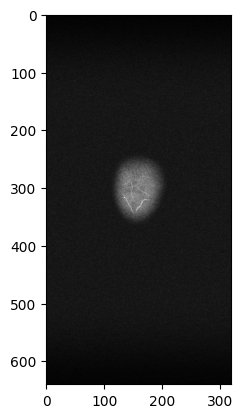

In [22]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [23]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [24]:
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

Let's see what the subsampled image looks like:

In [25]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

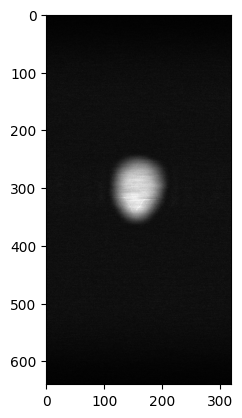

In [26]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')